# Week 11

In [14]:
#Exercise 13-1.
#In NSFG Cycles 6 and 7, the variable cmdivorcx contains the date of divorce for the
#respondent’s first marriage, if applicable, encoded in century-months.
#Compute the duration of marriages that have ended in divorce, and the duration, so far,
#of marriages that are ongoing. Estimate the hazard and survival function for the duration of marriage.

#Use resampling to take into account sampling weights, and plot data from several re‐samples
#to visualize sampling error. Consider dividing the respondents into groups by decade of birth, 
#and possibly by age at first marriage.

In [34]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")
 
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/1995FemRespData.dat.gz")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dct")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dat.gz")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemRespSetup.dct")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemResp.dat.gz")

download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/survival.py")


In [32]:
import nsfg
import survival as surv
import thinkplot
import thinkstats2
import numpy as np
import pandas as pd
import warnings

In [ ]:
preg = nsfg.ReadFemPreg()
resp = nsfg.ReadFemResp()

resp1995 = surv.ReadFemResp1995()
resp2002 = surv.ReadFemResp2002()
resp2010 = surv.ReadFemResp2010()

In [23]:
def CleanData(resp): 
    resp.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)

    resp["notdivorced"] = resp.cmdivorcx.isnull().astype(int)
    resp["duration"] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    resp["durationsofar"] = (resp.cmintvw - resp.cmmarrhx) / 12.0

    month0 = pd.to_datetime("1899-12-15")
    dates = [month0 + pd.DateOffset(months=cm) for cm in resp.cmbirth]
    resp["decade"] = (pd.DatetimeIndex(dates).year - 1900) // 10

In [24]:
CleanData(resp2002)
married2002 = resp2002[resp2002.evrmarry == 1]

CleanData(resp2010)
married2010 = resp2010[resp2010.evrmarry == 1]

In [25]:
def ResampleDivorceCurve(resps): 
    for _ in range(11):
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        PlotDivorceCurveByDecade(sample, color="#225EA8", alpha=0.1)

    thinkplot.Show(xlabel="years", axis=[0, 28, 0, 1])

In [26]:
def ResampleDivorceCurveByDecade(resps): 
    for i in range(41):
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby("decade")
        if i == 0:
            survival.AddLabelsByDecade(groups, alpha=0.7)

        EstimateSurvivalByDecade(groups, alpha=0.1)

    thinkplot.Config(xlabel="Years", ylabel="Fraction undivorced", axis=[0, 28, 0, 1])

In [27]:
def EstimateSurvivalByDecade(groups, **options): 
    thinkplot.PrePlot(len(groups))
    for name, group in groups:
        _, sf = EstimateSurvival(group)
        thinkplot.Plot(sf, **options)

In [28]:
def EstimateSurvival(resp): 
    complete = resp[resp.notdivorced == 0].duration.dropna()
    ongoing = resp[resp.notdivorced == 1].durationsofar.dropna()

    hf = survival.EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

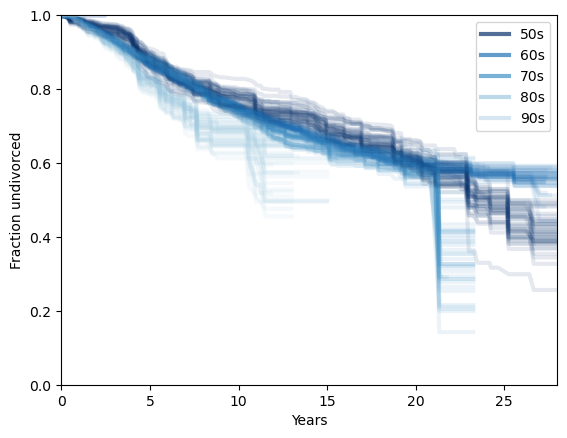

In [33]:
warnings.simplefilter(action='ignore', category=FutureWarning)
ResampleDivorceCurveByDecade([married2002, married2010])